# Validation Example for PINT paper

A comparison between PINT result and Tempo/Tempo2 result. This example is presented in the PINT paper. But it can be used for other datasets. 

* Requirement
  * Data set: NANOGrav 11-year data J1600-3053
  * TEMPO and its python utils tempo_utils. Download from https://github.com/demorest/tempo_utils
  * TEMPO2 and its python utils tempo2_utils. Download from https://github.com/demorest/tempo_utils
  * TEMPO2 general2 plugins. 


In [1]:
import pint
import sys
from pint import toa
from pint import models
from pint.fitter import GLSFitter
import os 
import matplotlib.pyplot as plt
import astropy.units as u
import tempo2_utils as t2u
import tempo_utils
import tempo2_utils
import numpy as np
from astropy.table import Table
from astropy.io import ascii
import subprocess
import tempfile
from pint import ls
import astropy.constants as ct
from pint.solar_system_ephemerides import objPosVel_wrt_SSB
from astropy.time import Time

### Print the PINT and TEMPO/TEMPO2 version

In [2]:
print("PINT version: ", pint.__version__)
tempo_v = subprocess.check_output(["tempo", "-v"])
print("TEMPO version: ", tempo_v.decode("utf-8"))
#Not sure why tempo2_v = subprocess.check_output(["tempo2", "-v"]) does not work.
process = subprocess.Popen(['tempo2', '-v'], stdout=subprocess.PIPE)
tempo2_v = process.communicate()[0]
print("TEMPO2 version: ", tempo2_v.decode("utf-8"))

PINT version:  0.7+432.g6854a9ec.dirty
TEMPO version:   Tempo v 13.101 (2020-11-04 c5fbddf)

TEMPO2 version:  2019.01.1



### Redefine the Tempo2_util function for larger number of observations

In [3]:
_nobs = 30000
def newpar2(parfile,timfile):
    """
    Run tempo2, return new parfile (as list of lines).  input parfile
    can be either lines or a filename.
    """
    orig_dir = os.getcwd()
    try:
        temp_dir = tempfile.mkdtemp(prefix="tempo2")
        try:
            lines = open(parfile,'r').readlines()
        except:
            lines = parfile
        open("%s/pulsar.par" % temp_dir, 'w').writelines(lines)
        timpath = os.path.abspath(timfile)
        os.chdir(temp_dir)
        cmd = "tempo2 -nobs %d -newpar -f pulsar.par %s -norescale" % (_nobs, timpath)
        os.system(cmd + " > /dev/null")
        outparlines = open('new.par').readlines()
    finally:
        os.chdir(orig_dir)
    os.system("rm -rf %s" % temp_dir)
    for l in outparlines:
        if l.startswith('TRES'): rms = float(l.split()[1])
        elif l.startswith('CHI2R'): (foo, chi2r, ndof) = l.split()
    return float(chi2r)*float(ndof), int(ndof), rms, outparlines

### Get the data file for PSR J1600-3053. 

* Note
  * For other data set, one can change the cell below. 

In [4]:
psr = "J1600-3053"
par_file = os.path.join('.', psr + "_NANOGrav_11yv1.gls.par")
tim_file = os.path.join('.', psr + "_NANOGrav_11yv1.tim")

## PINT run

### Load TOAs to PINT

In [5]:
t = toa.get_TOAs(tim_file, ephem="DE436", bipm_version="BIPM2015")

INFO: Applying clock corrections (include_GPS = True, include_BIPM = True) [pint.toa]
INFO: Observatory gbt, loading clock file 
	/home/luo/.local/lib/python3.6/site-packages/pint/datafiles/time.dat [pint.observatory.topo_obs]
INFO: Applying observatory clock corrections. [pint.observatory.topo_obs]
INFO: Applying GPS to UTC clock correction (~few nanoseconds) [pint.observatory.topo_obs]
INFO: Observatory gbt, loading GPS clock file 
	/home/luo/.local/lib/python3.6/site-packages/pint/datafiles/gps2utc.clk [pint.observatory.topo_obs]
INFO: Applying TT(TAI) to TT(BIPM) clock correction (~27 us) [pint.observatory.topo_obs]
INFO: Observatory gbt, loading BIPM clock file 
	/home/luo/.local/lib/python3.6/site-packages/pint/datafiles/tai2tt_bipm2015.clk [pint.observatory.topo_obs]
INFO: Computing TDB columns. [pint.toa]
INFO: Doing astropy mode TDB conversion [pint.observatory]
INFO: Computing PosVels of observatories and Earth, using DE436 [pint.toa]
INFO: Set solar system ephemeris to link:

In [6]:
print("There are {} TOAs in the dataset.".format(t.ntoas))

There are 12433 TOAs in the dataset.


### Load timing model from .par file

In [7]:
m = models.get_model(par_file)

INFO: Parameter A1DOT's value will be scaled by 1e-12 [pint.models.parameter]
INFO: Parameter A1DOT's value will be scaled by 1e-12 [pint.models.parameter]


### Make the General Least Square fitter

In [8]:
f = GLSFitter(model=m, toas=t)

### Fit TOAs for 9 iterations.

In [9]:
chi2 = f.fit_toas(9)
print("Postfit Chi2: ", chi2)
print("Degree of freedom: ", f.resids.dof)

Postfit Chi2:  12368.09539037636076
Degree of freedom:  12307



### The weighted RMS value for pre-fit and post-fit residuals

In [10]:
print(f.resids_init.rms_weighted())
print(f.resids.rms_weighted())

0.9441707008147506 us
0.9441138158055049 us


### Plot the pre-fit and post-fit residuals

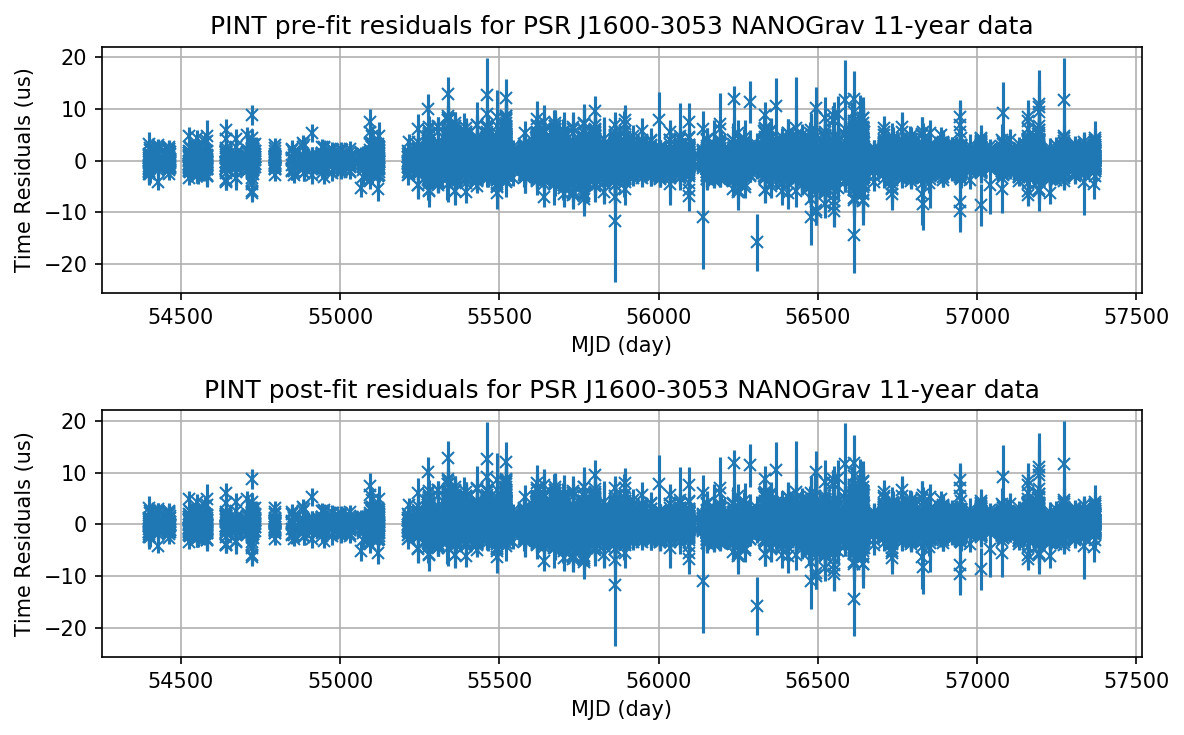

In [11]:
pint_prefit = f.resids_init.time_resids.to_value(u.us)
pint_postfit = f.resids.time_resids.to_value(u.us)

plt.figure(figsize=(8,5), dpi=150)
plt.subplot(2, 1, 1)
plt.errorbar(t.get_mjds().to_value(u.day), f.resids_init.time_resids.to_value(u.us), 
             yerr=t.get_errors().to_value(u.us), fmt='x')

plt.xlabel('MJD (day)')
plt.ylabel('Time Residuals (us)')
plt.title('PINT pre-fit residuals for PSR J1600-3053 NANOGrav 11-year data')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.errorbar(t.get_mjds().to_value(u.day), f.resids.time_resids.to_value(u.us), 
             yerr=t.get_errors().to_value(u.us), fmt='x')
plt.xlabel('MJD (day)')
plt.ylabel('Time Residuals (us)')
plt.title('PINT post-fit residuals for PSR J1600-3053 NANOGrav 11-year data')
plt.grid(True)
plt.tight_layout()
plt.savefig("J1600_PINT")

## TEMPO run

### Use tempo_utils to analysis the same data set.

In [12]:
tempo_toa = tempo_utils.read_toa_file(tim_file)
tempo_chi2, ndof, rms_t, tempo_par = tempo_utils.run_tempo(tempo_toa ,par_file, get_output_par=True, 
                                                   gls=True)

In [13]:
print("TEMPO postfit chi2: ", tempo_chi2)
print("TEMPO postfit weighted rms: ", rms_t)

TEMPO postfit chi2:  12368.46
TEMPO postfit weighted rms:  0.944


### Write the TEMPO postfit residuals to a new .par file, for comparison later

In [14]:
# Write out the post fit tempo parfile.
tempo_parfile = open(psr + '_tempo.par', 'w')
for line in tempo_par:
    tempo_parfile.write(line)
tempo_parfile.close()

### Get the TEMPO residuals

In [15]:
tempo_prefit = tempo_toa.get_prefit()
tempo_postfit = tempo_toa.get_resids()
mjds = tempo_toa.get_mjd()
freqs = tempo_toa.get_freq()
errs = tempo_toa.get_resid_err()

### Plot the PINT - TEMPO residual difference.

In [16]:
tp_diff_pre = (pint_prefit - tempo_prefit) * u.us 
tp_diff_post = (pint_postfit - tempo_postfit) * u.us

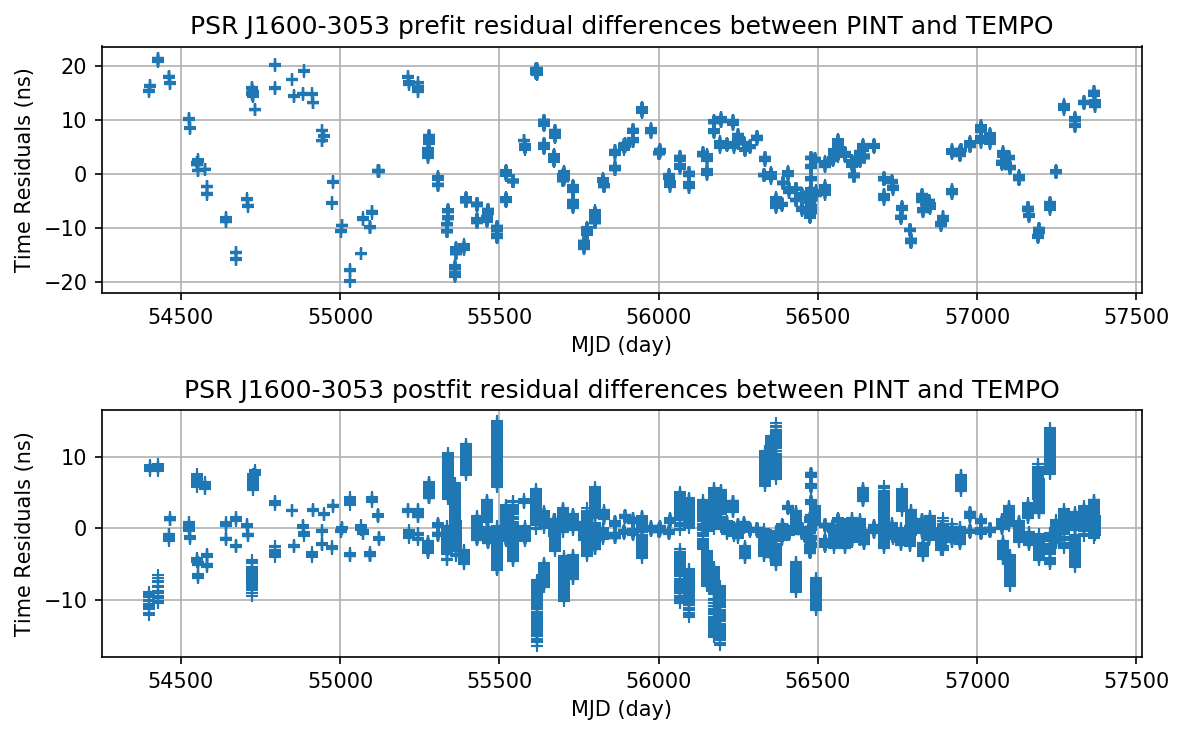

In [17]:
plt.figure(figsize=(8,5), dpi=150)
plt.subplot(2, 1, 1)
plt.plot(mjds, (tp_diff_pre - tp_diff_pre.mean()).to_value(u.ns), '+')
plt.xlabel('MJD (day)')
plt.ylabel('Time Residuals (ns)')
plt.title('PSR J1600-3053 prefit residual differences between PINT and TEMPO')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(mjds, (tp_diff_post - tp_diff_post.mean()).to_value(u.ns), '+')
plt.xlabel('MJD (day)')
plt.ylabel('Time Residuals (ns)')
plt.title('PSR J1600-3053 postfit residual differences between PINT and TEMPO')
plt.grid(True)
plt.tight_layout()
plt.savefig("J1600_PINT_tempo.eps")

### Compare the parameter between TEMPO and PINT

* Reported quantities
  * TEMPO value
  * TEMPO uncertainty 
  * Parameter units
  * TEMPO parameter value - PINT parameter value
  * TEMPO/PINT parameter absolute difference divided by TEMPO uncertainty 
  * PINT uncertainty divided by TEMPO uncertainty
  * If TEMPO provides the uncertainty value

In [18]:
# Create the parameter compare table
tv = []
tu = []
tv_pv = []
tv_pv_tc = []
tc_pc = []
units = []
names = []
no_t_unc = []
tempo_new_model = models.get_model(psr + '_tempo.par')
for param in tempo_new_model.params:
    t_par = getattr(tempo_new_model, param)
    pint_par = getattr(f.model, param)
    tempoq = t_par.quantity 
    pintq = pint_par.quantity
    try:
        diffq =  tempoq - pintq
        if t_par.uncertainty_value != 0.0:
            diff_tcq = np.abs(diffq) / t_par.uncertainty
            uvsu = pint_par.uncertainty / t_par.uncertainty
            no_t_unc.append(False)
        else:
            diff_tcq = np.abs(diffq) / pint_par.uncertainty
            uvsu = t_par.uncertainty
            no_t_unc.append(True)
    except TypeError:
        continue
    uvsu = pint_par.uncertainty / t_par.uncertainty
    tv.append(tempoq.value)
    tu.append(t_par.uncertainty.value)
    tv_pv.append(diffq.value)
    tv_pv_tc.append(diff_tcq.value)
    tc_pc.append(uvsu)
    units.append(t_par.units)
    names.append(param)
    
compare_table = Table((names, tv, tu, units, tv_pv, tv_pv_tc, tc_pc, no_t_unc), names = ('name', 'Tempo Value', 'Tempo uncertainty', 'units', 
                                                                                      'Tempo_V-PINT_V', 
                                                                                      'Tempo_PINT_diff/unct', 
                                                                                      'PINT_unct/Tempo_unct', 
                                                                                      'no_t_unc')) 
compare_table.sort('Tempo_PINT_diff/unct')
compare_table = compare_table[::-1]
compare_table.write('parameter_compare.t.html', format='html', overwrite=True)

INFO: Parameter A1DOT's value will be scaled by 1e-12 [pint.models.parameter]
INFO: Parameter A1DOT's value will be scaled by 1e-12 [pint.models.parameter]


### Print the parameter difference in a table.

The table is sorted by relative difference in descending order. 

In [19]:
compare_table

name,Tempo Value,Tempo uncertainty,units,Tempo_V-PINT_V,Tempo_PINT_diff/unct,PINT_unct/Tempo_unct,no_t_unc
str8,str32,float128,object,float128,float128,float128,bool
ELONG,244.347677844079,5.9573e-09,deg,-5.921065165948036224e-10,0.09939175743957894053,0.9999766504295133643,False
ELAT,-10.0718390253651,3.36103e-08,deg,-3.1913434074201663115e-09,0.094951351443461269657,1.000072183713741608,False
PMELONG,0.4626,0.010399999999999999523,mas / yr,0.00071187905827979625073,0.068449909449980417264,1.0031591779004100928,False
F0,277.9377112429746148,5.186e-13,Hz,-1.471045507628332416e-14,0.028365705893334601157,1.0000736554074983135,False
PX,0.504,0.07349999999999999589,mas,-0.0020703029707025422113,0.028167387356497174122,0.99982582356450722116,False
ECC,0.0001737294,8.9000000000000002855e-09,,-2.384406823461443503e-10,0.02679108790406116089,1.0022775207693099819,False
DMX_0010,0.00066927561,0.00020051850499999999489,pc / cm3,-5.0847948039543485257e-06,0.025358232168918019844,0.99999786016599179206,False
DMX_0001,0.0016432056,0.00022434462499999998828,pc / cm3,-5.328772561611662406e-06,0.023752619710018293281,1.0000068575953371397,False
DMX_0002,0.00136024872,0.00020941304000000001188,pc / cm3,-4.905837050632510035e-06,0.023426607295479354859,1.000010656028552436,False


### If one wants the Latex output please use the cell below. 

In [20]:
#ascii.write(compare_table, sys.stdout, Writer = ascii.Latex,
#            latexdict = {'tabletype': 'table*'})

### Check out the maximum DMX difference

In [21]:
max_dmx = 0
max_dmx_index = 0
for ii, row in enumerate(compare_table):
    if row['name'].startswith('DMX_'):
        if row['Tempo_PINT_diff/unct'] > max_dmx:
            max_dmx = row['Tempo_PINT_diff/unct']
            max_dmx_index = ii

dmx_max = compare_table[max_dmx_index]['name']

compare_table[max_dmx_index]


name,Tempo Value,Tempo uncertainty,units,Tempo_V-PINT_V,Tempo_PINT_diff/unct,PINT_unct/Tempo_unct,no_t_unc
str8,str32,float128,object,float128,float128,float128,bool
DMX_0010,0.00066927561,0.00020051850499999999489,pc / cm3,-5.0847948039543485257e-06,0.025358232168918019844,0.99999786016599179206,False


### Output the table in the paper

In [22]:
paper_params = ['F0', 'F1', 'FD1', 'FD2', 'JUMP1', 'PX', 
                'ELONG', 'ELAT', 'PMELONG', 'PMELAT', 'PB', 
                'A1', 'A1DOT', 'ECC', 'T0', 'OM', 'OMDOT', 'M2',
                'SINI', dmx_max]
# Get the table index of the parameters above
paper_param_index = []
for pp in paper_params:
    # We assume the parameter name are unique in the table
    idx = np.where(compare_table['name'] == pp)[0][0]
    paper_param_index.append(idx)
paper_param_index = np.array(paper_param_index)
compare_table[paper_param_index]

name,Tempo Value,Tempo uncertainty,units,Tempo_V-PINT_V,Tempo_PINT_diff/unct,PINT_unct/Tempo_unct,no_t_unc
str8,str32,float128,object,float128,float128,float128,bool
F0,277.9377112429746148,5.186e-13,Hz,-1.471045507628332416e-14,0.028365705893334601157,1.0000736554074983135,False
F1,-7.338737472765e-16,4.619148184227e-21,Hz / s,6.3513794158537125015e-23,0.013750109679403142984,1.0001125509037762049,False
FD1,3.98314325e-05,1.6566479199999999207e-06,s,-2.5078110490474835037e-09,0.0015137863747461100493,0.99999722077930985886,False
FD2,-1.47296057e-05,1.1922595999999999884e-06,s,1.3481392263201306481e-09,0.0011307430246903700001,0.9999985886156963488,False
JUMP1,-8.789e-06,1.2999999999999999941e-07,s,-4.662519179964242028e-10,0.0035865532153571094524,1.0037094614491930411,False
PX,0.504,0.07349999999999999589,mas,-0.0020703029707025422113,0.028167387356497174122,0.99982582356450722116,False
ELONG,244.347677844079,5.9573e-09,deg,-5.921065165948036224e-10,0.09939175743957894053,0.9999766504295133643,False
ELAT,-10.0718390253651,3.36103e-08,deg,-3.1913434074201663115e-09,0.094951351443461269657,1.000072183713741608,False
PMELONG,0.4626,0.010399999999999999523,mas / yr,0.00071187905827979625073,0.068449909449980417264,1.0031591779004100928,False


## TEMPO2 run

Before TEMPO2 run, the .par file has to be modified for a more accurate TEMPO2 vs PINT comparison. We save the modified .par file in a file named "[PSR name]_tempo2.par". In this case, "J1600-3053_tempo2.par"

* Modified parameters 
  * ECL IERS2010   ----> ECL IERS 2003   (TEMPO2 use IERS 2003 Obliquity angle as default)
  * T2CMETHOD TEMPO  ----> # T2CMETHOD TEMPO (Make TEMPO2 ues the new precession and nutation model IAU 2000)

In [23]:
tempo2_par = "J1600-3053_tempo2.par"

In [24]:
less J1600-3053_tempo2.par

### PINT refit using the modified tempo2-style parfile

In [25]:
m_t2 = models.get_model(tempo2_par)

INFO: Parameter A1DOT's value will be scaled by 1e-12 [pint.models.parameter]
INFO: Parameter A1DOT's value will be scaled by 1e-12 [pint.models.parameter]


In [26]:
f_t2 = GLSFitter(toas=t, model=m_t2)
f_t2.fit_toas()

12368.094237187552177

### Tempo2 fit

In [27]:
tempo2_chi2, ndof, rms_t2, tempo2_new_par = newpar2(tempo2_par, tim_file)
print("TEMPO2 chi2: ", tempo2_chi2)
print("TEMPO2 rms: ", rms_t2)

TEMPO2 chi2:  12265.156200000001
TEMPO2 rms:  0.944


### Get TEMPO2 residuals, toa value, observing frequencies, and data error

In [28]:
tempo2_result = t2u.general2(tempo2_par, tim_file, ['sat', 'pre', 'post', 'freq', 'err'])
# TEMPO2's residual unit is second
tp2_diff_pre = f_t2.resids_init.time_resids - tempo2_result['pre'] * u.s
tp2_diff_post = f_t2.resids.time_resids - tempo2_result['post'] * u.s

### Plot the TEMPO2 - PINT residual difference

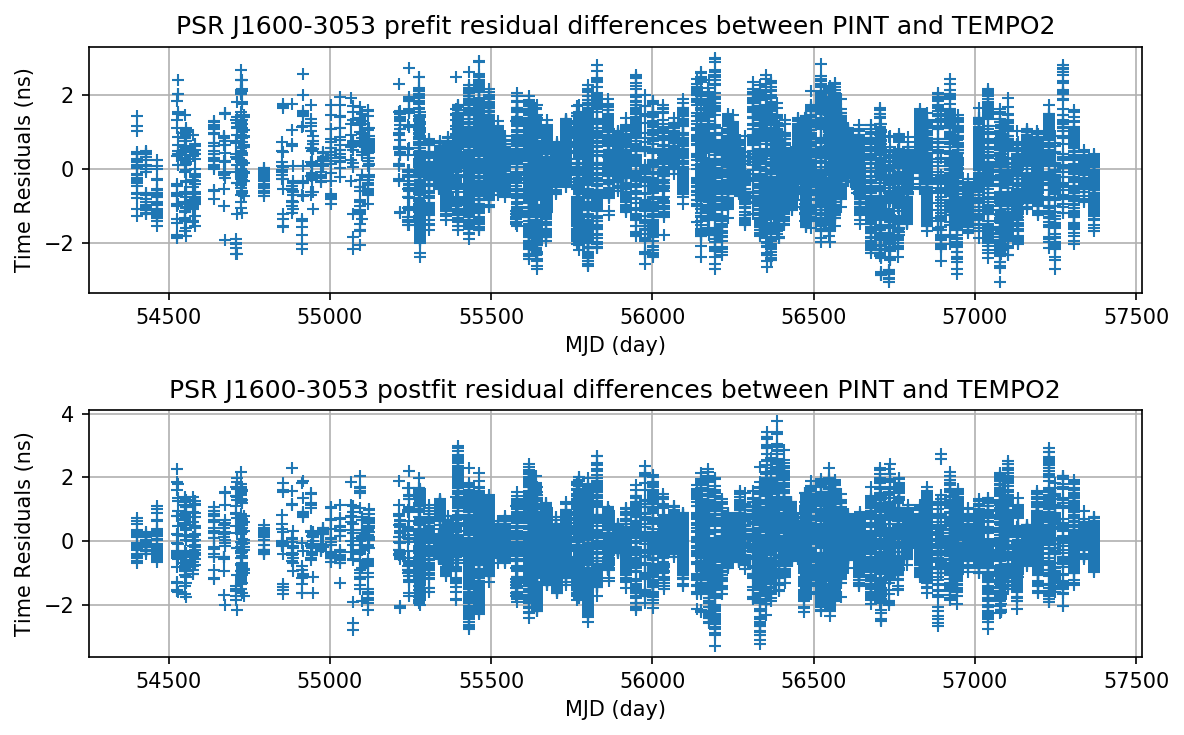

In [29]:
plt.figure(figsize=(8,5), dpi=150)
plt.subplot(2, 1, 1)
plt.plot(mjds, (tp2_diff_pre - tp2_diff_pre.mean()).to_value(u.ns), '+')
plt.xlabel('MJD (day)')
plt.ylabel('Time Residuals (ns)')
plt.title('PSR J1600-3053 prefit residual differences between PINT and TEMPO2')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(mjds, (tp2_diff_post - tp2_diff_post.mean()).to_value(u.ns), '+')
plt.xlabel('MJD (day)')
plt.ylabel('Time Residuals (ns)')
plt.title('PSR J1600-3053 postfit residual differences between PINT and TEMPO2')
plt.grid(True)
plt.tight_layout()
plt.savefig("J1600_PINT_tempo2")

### Write out the TEMPO2 postfit parameter to a new file

* Note, since the ECL parameter is hard coded in tempo2, we will have to add it manually 

In [30]:
# Write out the post fit tempo parfile.
tempo2_parfile = open(psr + '_new_tempo2.2.par', 'w')
for line in tempo2_new_par:
    tempo2_parfile.write(line)
tempo2_parfile.write("ECL IERS2003")
tempo2_parfile.close()

### Compare the parameter between TEMPO2 and PINT

* Reported quantities
  * TEMPO2 value
  * TEMPO2 uncertainty 
  * Parameter units
  * TEMPO2 parameter value - PINT parameter value
  * TEMPO2/PINT parameter absolute difference divided by TEMPO2 uncertainty 
  * PINT uncertainty divided by TEMPO2 uncertainty
  * If TEMPO2 provides the uncertainty value

In [31]:
# Create the parameter compare table
tv = []
t2_unc = []
tv_pv = []
tv_pv_tc = []
tc_pc = []
units = []
names = []
no_t2_unc = []
tempo2_new_model = models.get_model(psr + '_new_tempo2.2.par')
for param in tempo2_new_model.params:
    t2_par = getattr(tempo2_new_model, param)
    pint2_par = getattr(f_t2.model, param)
    tempo2q = t2_par.quantity 
    pint2q = pint2_par.quantity
    try:
        diff2q =  tempo2q - pint2q
        if t2_par.uncertainty_value != 0.0:
            diff_tcq = np.abs(diff2q) / t2_par.uncertainty
            uvsu = pint2_par.uncertainty / t2_par.uncertainty
            no_t2_unc.append(False)
        else:
            diff_tcq = np.abs(diff2q) / pint2_par.uncertainty
            uvsu = t2_par.uncertainty
            no_t2_unc.append(True)
    except TypeError:
        continue
    uvsu = pint2_par.uncertainty / t2_par.uncertainty
    tv.append(tempo2q.value)
    t2_unc.append(t2_par.uncertainty.value)
    tv_pv.append(diff2q.value)
    tv_pv_tc.append(diff_tcq.value)
    tc_pc.append(uvsu)
    units.append(t2_par.units)
    names.append(param)
    
compare_table2 = Table((names, tv, t2_unc,units, tv_pv, tv_pv_tc, tc_pc, no_t2_unc), names = ('name', 'Tempo2 Value', 'T2 unc','units', 
                                                                                      'Tempo2_V-PINT_V', 
                                                                                      'Tempo2_PINT_diff/unct', 
                                                                                      'PINT_unct/Tempo2_unct', 
                                                                                      'no_t_unc')) 
compare_table2.sort('Tempo2_PINT_diff/unct')
compare_table2 = compare_table2[::-1]
compare_table2.write('parameter_compare.t2.html', format='html', overwrite=True)

/home/luo/.local/lib/python3.6/site-packages/astropy/units/quantity.py:464: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


### Print the parameter difference in a table.
The table is sorted by relative difference in descending order. 

In [32]:
compare_table2

name,Tempo2 Value,T2 unc,units,Tempo2_V-PINT_V,Tempo2_PINT_diff/unct,PINT_unct/Tempo2_unct,no_t_unc
str8,str32,float128,object,float128,float128,float128,bool
ECC,0.00017372966157521168,8.922286680669999241e-09,,4.168033894912624715e-11,0.0046714861829564476026,1.0000400789683185909,False
DMX_0098,0.0013394613122489417,0.00019579968831114546654,pc / cm3,-5.162393215032545085e-07,0.0026365686582855950293,0.99999926235860314705,False
DMX_0070,-0.00023747963906517973,0.00019767137320477682749,pc / cm3,-4.6318680163804021657e-07,0.0023432163905605278911,1.0000006066661308868,False
DMX_0097,0.0013928330661987446,0.00019620100461426303326,pc / cm3,-4.3591375636898264945e-07,0.0022217712759728318155,0.99999985479541497746,False
DMX_0055,-0.0005307704904403621,0.00019675128861832102923,pc / cm3,-3.936735762570617997e-07,0.0020008691125817808752,1.0000000155376389532,False
DMX_0063,-0.00048410571072825574,0.00019894769104906708185,pc / cm3,-3.8388090987831295642e-07,0.0019295569999032320674,1.0000001737671666557,False
DMX_0079,0.00018976795294000216,0.00019490725481464179483,pc / cm3,-3.6413058978400727507e-07,0.0018682249161545991592,1.0000001869460202197,False
DMX_0010,0.00067403356955979,0.00020051850482404336064,pc / cm3,-3.734867366063333513e-07,0.001862604835070314456,0.9999998791435175116,False
F1,-7.3387383041227678664e-16,4.619148404392432094e-21,Hz / s,-8.212906306513322778e-24,0.001778013085421442844,0.999998198306420979,False


### If one wants to get the latex version, please use the line below.

In [33]:
#ascii.write(compare_table2, sys.stdout, Writer = ascii.Latex,
#            latexdict = {'tabletype': 'table*'})

### Check out the maximum DMX difference

In [34]:
max_dmx = 0
max_dmx_index = 0
for ii, row in enumerate(compare_table2):
    if row['name'].startswith('DMX_'):
        if row['Tempo2_PINT_diff/unct'] > max_dmx:
            max_dmx = row['Tempo2_PINT_diff/unct']
            max_dmx_index = ii

dmx_max2 = compare_table2[max_dmx_index]['name']

compare_table2[max_dmx_index]

name,Tempo2 Value,T2 unc,units,Tempo2_V-PINT_V,Tempo2_PINT_diff/unct,PINT_unct/Tempo2_unct,no_t_unc
str8,str32,float128,object,float128,float128,float128,bool
DMX_0098,0.0013394613122489417,0.00019579968831114546654,pc / cm3,-5.162393215032545085e-07,0.0026365686582855950293,0.99999926235860314705,False


### Output the table in the paper

In [35]:
paper_params = ['F0', 'F1', 'FD1', 'FD2', 'JUMP1', 'PX', 
                'ELONG', 'ELAT', 'PMELONG', 'PMELAT', 'PB', 
                'A1', 'A1DOT', 'ECC', 'T0', 'OM', 'OMDOT', 'M2',
                'SINI', dmx_max]
# Get the table index of the parameters above
paper_param_index = []
for pp in paper_params:
    # We assume the parameter name are unique in the table
    idx = np.where(compare_table2['name'] == pp)[0][0]
    paper_param_index.append(idx)
paper_param_index = np.array(paper_param_index)
compare_table2[paper_param_index]

name,Tempo2 Value,T2 unc,units,Tempo2_V-PINT_V,Tempo2_PINT_diff/unct,PINT_unct/Tempo2_unct,no_t_unc
str8,str32,float128,object,float128,float128,float128,bool
F0,277.93771124297462788,5.1859268946902080184e-13,Hz,-6.6613381477509392425e-16,0.0012845029023782387781,1.0000082417695045875,False
F1,-7.3387383041227678664e-16,4.619148404392432094e-21,Hz / s,-8.212906306513322778e-24,0.001778013085421442844,0.999998198306420979,False
FD1,3.983282287426775e-05,1.6566478062738200598e-06,s,-1.6031694728325007922e-09,0.0009677189483251698093,1.0000000032094340519,False
FD2,-1.4729805752137882e-05,1.1922596055992699934e-06,s,1.4162333940147552079e-09,0.001187856560235392954,1.0000000136320319477,False
JUMP1,-8.7887456483184e-06,0.0,s,-5.0316350075314342574e-11,0.0003856129036950526755,inf,True
PX,0.5061242012322064,0.07348886965486496614,mas,1.9718059246720542887e-05,0.00026831354651833601603,1.0000000164253699531,False
ELONG,244.34767784255382,5.95727548431e-09,deg,9.322320693172514439e-12,0.0015648631186731613756,1.0000013810109530107,False
ELAT,-10.071839047043065,3.361025894297e-08,deg,-1.5125678487493132707e-11,0.00045003159639913618783,0.9999926235884047247,False
PMELONG,0.4619096015625491,0.010433361011620021289,mas / yr,7.3610413870994761965e-06,0.00070552925168612602887,1.0000025739354863052,False


### The residual difference between PINT and TEMPO2 is at the level of ~1ns. 

* We believe the discrepancy is mainly from the solar system geometric delay. 
* We will use the tempo2 postfit parameters, which are wrote out to `J1600-3053_new_tempo2.2.par`

In [36]:
tempo2_result2 = t2u.general2('J1600-3053_new_tempo2.2.par', tim_file, ['sat', 'pre', 'post', 'freq', 'err'])
m_t22 = models.get_model('J1600-3053_new_tempo2.2.par')
f_t22 = GLSFitter(toas=t, model=m_t22)
f_t22.fit_toas()
tp2_diff_pre2 = f_t22.resids_init.time_resids - tempo2_result2['pre'] * u.s
tp2_diff_post2 = f_t22.resids.time_resids - tempo2_result2['post'] * u.s

In [37]:
PINT_solar = m_t22.solar_system_geometric_delay(t)
tempo2_solar = t2u.general2('J1600-3053_new_tempo2.2.par', tim_file, ['roemer'])

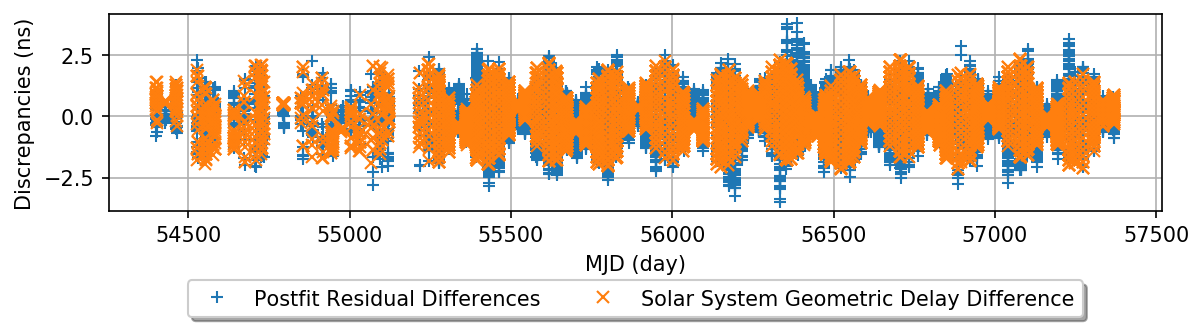

In [38]:
diff_solar = PINT_solar + tempo2_solar['roemer'] * u.s
plt.figure(figsize=(8,2.5), dpi=150)
plt.plot(mjds, (tp2_diff_post2 - tp2_diff_post2.mean()).to_value(u.ns), '+')
plt.plot(mjds, (diff_solar - diff_solar.mean()).to_value(u.ns, equivalencies=[(ls, u.s)]), 'x')

plt.xlabel('MJD (day)')
plt.ylabel('Discrepancies (ns)')
#plt.title('PSR J1600-3053 postfit residual differences between PINT and TEMPO2')
plt.grid(True)
plt.legend(['Postfit Residual Differences', 'Solar System Geometric Delay Difference'],
           loc='upper center', bbox_to_anchor=(0.5, -0.3), shadow=True, ncol=2)
plt.tight_layout()
plt.savefig("solar_geo")